In [39]:
# ============================================================
# BGMM Regime Detection — Combined Script
# - Leak-safe robust scaling
# - Train-only whitening for Train→Test; full-sample whitening for Full run
# - BGMM with persistence
# - Plots: (1) Train vs Test, (2) Full Sample
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pandas.tseries.offsets import MonthEnd
from scipy.stats import median_abs_deviation
from sklearn.mixture import BayesianGaussianMixture
from sklearn.covariance import LedoitWolf
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

FEATURES_XLSX = r"C:\Users\guoqi\Desktop\top_features_df.csv"
RETURNS_CSV   = r"C:\Users\guoqi\Desktop\Initial Data Package for Cornell Capstone Project\df_1M_ret.csv"

RETURN_COL = "Russell 1000"   

START_DATE = pd.Timestamp("1990-01-31")
END_DATE   = None
TRAIN_END  = pd.Timestamp("2019-12-01")

# Robust scaling
ROLL_WIN  = 24
Z_CLIP    = 4.0

# BGMM (penalized)
N_COMPONENTS_MAX = 5
COVARIANCE_TYPE  = "tied"          # try "diag" for extra stability after whitening
WCP_TYPE         = "dirichlet_process"
WCP              = 2.0
MEAN_PRECISION   = 0.05
REG_COV          = 5e-4
MAX_ITER         = 2000
RANDOM_STATE     = 42
TINY_WEIGHT      = 1e-4

# Persistence
ENABLE_SMOOTHING_HYSTERESIS = True
SMOOTH_WINDOW = 3
HIGH_THR      = 0.60
LOW_THR       = 0.40
ENABLE_MIN_DWELL = True
MIN_DWELL        = 3


In [40]:
def load_monthly(path: str) -> pd.DataFrame:
    if path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    else:
        df.index = pd.to_datetime(df.index)
    # month-end align
    return df.sort_index().resample("M").last()

def robust_roll_scale(dfin: pd.DataFrame, win: int = 24, clip: float = 4.0) -> pd.DataFrame:
    med = dfin.rolling(win, min_periods=max(6, win//3)).median()
    mad = dfin.rolling(win, min_periods=max(6, win//3)).apply(
        lambda x: median_abs_deviation(x, scale='normal'), raw=False
    )
    med_lag = med.shift(1)
    mad_lag = mad.shift(1).where(lambda s: s > 1e-8, 1e-8)
    z = (dfin - med_lag) / mad_lag
    return z.clip(-clip, clip).dropna()

def make_whitener(Z_center_for_cov: pd.DataFrame):
    """Return Winv_sqrt based on Ledoit–Wolf fit on provided centered matrix."""
    lw = LedoitWolf().fit(Z_center_for_cov.values)
    Sigma_hat = lw.covariance_
    lam, V = np.linalg.eigh(Sigma_hat)
    Winv_sqrt = V @ np.diag(1.0 / np.sqrt(np.clip(lam, 1e-8, None))) @ V.T
    return Winv_sqrt


def combine_and_scale_features_only(FEATURES_XLSX, start, end):
    """
    Load macro/features ONLY (no returns), align to month-end, 
    filter missingness, and robust-roll-scale.
    Returns:
        df_feat : original (filtered) features at monthly frequency
        Z       : robust-rolled z-scores (leak-safe) used by BGMM
    """
    # Load features, forward-fill a bit for mild gaps
    df_feat = load_monthly(FEATURES_XLSX).ffill(limit=12).loc[start:end]

    # Keep columns with enough history
    col_keep = df_feat.columns[df_feat.notna().mean() >= 0.50]
    panel = df_feat[col_keep].copy()

    # Keep months with enough cross-section completeness
    row_keep = panel.index[panel.notna().mean(axis=1) >= 0.80]
    panel = panel.loc[row_keep].copy().ffill(limit=3).dropna(how="any")

    # Leak-safe robust scaling (median/MAD with a 1-month lag)
    Z = robust_roll_scale(panel, win=ROLL_WIN, clip=Z_CLIP)
    return panel, Z  # return 'panel' (features only), not a join with returns

def hysteresis_labels(resp_df: pd.DataFrame, high_thr=0.6, low_thr=0.4, win=3) -> pd.Series:
    rs = resp_df.rolling(win, min_periods=1).mean()
    labels, prev_k = [], None
    for t in rs.index:
        p = rs.loc[t].values
        k_now = int(np.argmax(p))
        if prev_k is None:
            prev_k = k_now
        else:
            if k_now != prev_k:
                if (p[prev_k] < low_thr) and (p[k_now] > high_thr):
                    prev_k = k_now
        labels.append(prev_k)
    return pd.Series(labels, index=rs.index, name="regime_id")

def enforce_min_dwell(labels: pd.Series, resp_df: pd.DataFrame, min_len: int = 3) -> pd.Series:
    lab = labels.copy().astype(int)
    idx = lab.index
    start = 0
    while start < len(lab):
        end = start
        while end + 1 < len(lab) and lab.iloc[end + 1] == lab.iloc[start]:
            end += 1
        run_len = end - start + 1
        if run_len < min_len:
            left_k  = lab.iloc[start - 1] if start - 1 >= 0 else None
            right_k = lab.iloc[end + 1]   if end + 1 < len(lab) else None
            if (left_k is None) and (right_k is None):
                pass
            elif (left_k is None) or (right_k is None):
                repl = left_k if right_k is None else right_k
                lab.iloc[start:end + 1] = repl
            else:
                win = idx[start:end + 1]
                p_left  = float(resp_df.loc[win, f"k{left_k}"].mean())
                p_right = float(resp_df.loc[win, f"k{right_k}"].mean())
                lab.iloc[start:end + 1] = left_k if p_left >= p_right else right_k
        start = end + 1
    return lab

def make_bgmm():
    return BayesianGaussianMixture(
        n_components=N_COMPONENTS_MAX,
        covariance_type=COVARIANCE_TYPE,
        weight_concentration_prior_type=WCP_TYPE,
        weight_concentration_prior=WCP,
        mean_precision_prior=MEAN_PRECISION,
        reg_covar=REG_COV,
        init_params="kmeans",
        max_iter=MAX_ITER,
        random_state=RANDOM_STATE
    )

def assign_with_persistence(resp_df: pd.DataFrame, weights: np.ndarray) -> pd.Series:
    tiny_idx = set(np.where(weights < TINY_WEIGHT)[0].tolist())
    lab = hysteresis_labels(resp_df, high_thr=HIGH_THR, low_thr=LOW_THR, win=SMOOTH_WINDOW)
    lab = lab.where(~lab.isin(tiny_idx), -1)
    if ENABLE_MIN_DWELL:
        lab = enforce_min_dwell(lab, resp_df, min_len=MIN_DWELL)
    return lab.rename("regime_id")


In [41]:
# plotting
def _runs(index, values):
    start = None; prev = None; last_t = None
    for t, v in zip(index, values):
        if pd.isna(v):
            if start is not None:
                yield start, last_t, prev
                start = None; prev = None
        else:
            if (start is None) or (v != prev):
                if start is not None:
                    yield start, last_t, prev
                start = t; prev = v
        last_t = t
    if start is not None:
        yield start, last_t, prev

def _palette(K):
    base = ["#0072B2","#E69F00","#009E73","#D55E00","#CC79A7",
            "#56B4E9","#F0E442","#000000","#999999"]
    return (base * (K // len(base) + 1))[:K]

def _format_dates(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(alpha=0.15, linestyle=":", linewidth=0.8)

def plot_train_test_merged(reg_tr: pd.Series,
                           reg_te: pd.Series,
                           split_date: pd.Timestamp,
                           title: str = "BGMM regimes — Train (left) vs Test (right)"):
    """
    Merge TRAIN and TEST regime series on one axis, with a dashed split line.
    Assumes TEST labels are projected from the TRAIN-fit model (same IDs).
    """
    # make a single series: take train on/before split, test strictly after
    s_tr = reg_tr.copy()
    s_te = reg_te.copy()
    # ensure integer IDs, allow -1 for masked
    s_tr = s_tr.astype("int64")
    s_te = s_te.astype("int64")

    # combine: keep train up to split_date, test after split_date
    merged = pd.concat([s_tr.loc[:split_date], s_te.loc[split_date + MonthEnd(1):]])
    merged.name = "regime_id"

    # number of used components (>=0)
    K = int(merged[merged >= 0].max() if (merged >= 0).any() else -1) + 1
    pal = _palette(K)

    fig, ax = plt.subplots(figsize=(15, 4.2))

    # draw colored spans per contiguous run
    y_plot = merged.astype(float).where(lambda x: x >= 0) + 1  # shift to 1..K for display
    for st, en, val in _runs(y_plot.index, y_plot.values):
        if np.isnan(val):
            continue
        rid = int(val - 1)
        ax.axvspan(st, en, color=pal[rid], alpha=0.20, lw=0)

    # step line on top
    ax.plot(y_plot.index, y_plot.values, color="k", lw=2.0, drawstyle="steps-post")

    # y-axis labels
    if K > 0:
        ax.set_yticks(np.arange(1, K + 1))
        ax.set_yticklabels([f"Regime {i+1}" for i in range(K)], fontsize=9)
        ax.set_ylim(0.5, K + 0.5)

    # dashed split line + annotations
    ax.axvline(split_date, color="k", ls="--", lw=1.2, alpha=0.8)
    # small headers
    xmin, xmax = y_plot.index.min(), y_plot.index.max()
    ax.text(xmin, K + 0.45, "TRAIN", va="bottom", ha="left", fontsize=10, weight="bold")
    ax.text(split_date, K + 0.45, "TEST", va="bottom", ha="left", fontsize=10, weight="bold")

    # legend with regime colors
    handles = [Patch(facecolor=pal[i], alpha=0.20, edgecolor="none", label=f"Regime {i+1}")
               for i in range(K)]
    ax.legend(handles=handles, loc="upper left", ncol=min(K, 5), frameon=False)

    _format_dates(ax)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Date"); ax.set_ylabel("Regime ID")
    plt.tight_layout(); plt.show()

def plot_full(reg: pd.Series, title="BGMM Market Regimes — Full Sample"):
    K = int(reg[reg>=0].max() if (reg>=0).any() else -1) + 1
    pal = _palette(K)
    fig, ax = plt.subplots(figsize=(15, 3.8))
    y = reg.astype(float).where(lambda x: x>=0) + 1
    for st, en, val in _runs(y.index, y.values):
        if np.isnan(val): continue
        rid = int(val-1)
        ax.axvspan(st, en, color=pal[rid], alpha=0.20, lw=0)
    ax.plot(y.index, y.values, color="k", lw=2.0, drawstyle="steps-post")
    if K > 0:
        ax.set_yticks(np.arange(1, K+1))
        ax.set_yticklabels([f"Regime {i+1}" for i in range(K)], fontsize=9)
        ax.set_ylim(0.5, K+0.5)
    ax.set_title(title)
    _format_dates(ax)
    ax.set_xlabel("Date"); ax.set_ylabel("Regime ID")
    plt.tight_layout(); plt.show()

C:\Users\guoqi\AppData\Local\Temp\ipykernel_49096\1505676053.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.sort_index().resample("M").last()


Active TRAIN regimes: 4
Active TEST regimes : 4


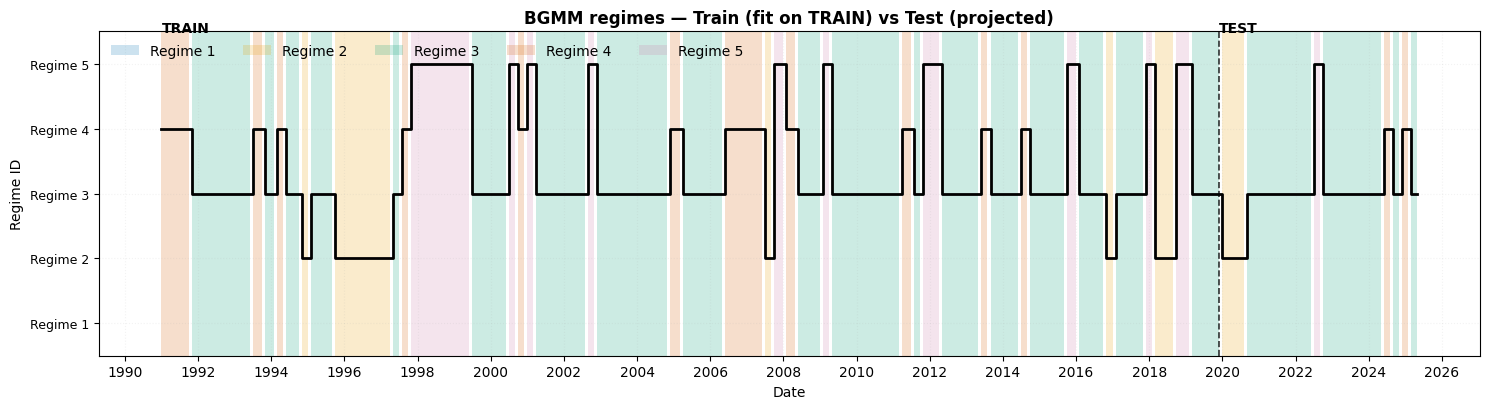

Active FULL-SAMPLE regimes: 5


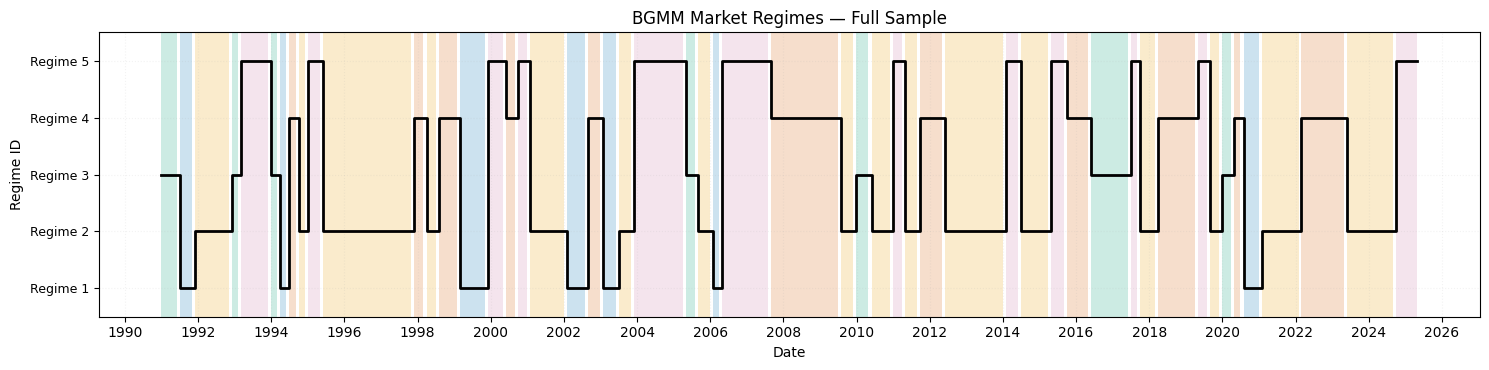


OOS diagnostics — LL gap: 12.32 | AMI: 0.068 | ARI: 0.020


In [42]:
# data scaling
# df_m, Z = combine_and_scale(FEATURES_XLSX, RETURNS_CSV, RETURN_COL, START_DATE, END_DATE)
df_m, Z = combine_and_scale_features_only(FEATURES_XLSX, START_DATE, END_DATE)

# TRAIN→TEST (train-only whitening) 
Z_tr = Z.loc[:TRAIN_END]
Z_te = Z.loc[TRAIN_END + MonthEnd(1):]  # strict split

# center & whiten using TRAIN only
mu_tr = Z_tr.mean()
Zc_tr = Z_tr - mu_tr
Zc    = Z - mu_tr
Winv_train = make_whitener(Zc_tr)
X      = pd.DataFrame(Zc.values @ Winv_train, index=Z.index, columns=Z.columns)
X_train = X.loc[:TRAIN_END]
X_test  = X.loc[TRAIN_END + MonthEnd(1):]

# fit on TRAIN, project both
bg_tr = make_bgmm().fit(X_train.values)
resp_tr = pd.DataFrame(bg_tr.predict_proba(X_train.values), index=X_train.index,
                       columns=[f"k{j}" for j in range(bg_tr.n_components)])
resp_te = pd.DataFrame(bg_tr.predict_proba(X_test.values),  index=X_test.index,
                       columns=resp_tr.columns)

reg_train = assign_with_persistence(resp_tr, bg_tr.weights_)
reg_test  = assign_with_persistence(resp_te, bg_tr.weights_)
print("Active TRAIN regimes:", int(reg_train[reg_train>=0].nunique()))
print("Active TEST regimes :", int(reg_test[reg_test>=0].nunique()))

# Plot TRAIN/TEST (two panels)
plot_train_test_merged(reg_train, reg_test, TRAIN_END,
                       title="BGMM regimes — Train (fit on TRAIN) vs Test (projected)")


# FULL-SAMPLE (full-sample whitening & fit)
mu_full = Z.mean()
Zc_full = Z - mu_full
Winv_full = make_whitener(Zc_full)
X_full = pd.DataFrame(Zc_full.values @ Winv_full, index=Z.index, columns=Z.columns)

bg_full = make_bgmm().fit(X_full.values)
resp_full = pd.DataFrame(bg_full.predict_proba(X_full.values), index=X_full.index,
                         columns=[f"k{j}" for j in range(bg_full.n_components)])
reg_full = assign_with_persistence(resp_full, bg_full.weights_)
print("Active FULL-SAMPLE regimes:", int(reg_full[reg_full>=0].nunique()))

# Plot FULL sample (one panel)
plot_full(reg_full)

# Optional OOS diagnostics (agreement)
if len(X_test) > 0:
    y_te_proj  = pd.Series(bg_tr.predict(X_test.values),  index=X_test.index)
    bg_te_ref  = make_bgmm().fit(X_test.values)
    y_te_refit = pd.Series(bg_te_ref.predict(X_test.values), index=X_test.index)
    ami = adjusted_mutual_info_score(y_te_proj, y_te_refit)
    ari = adjusted_rand_score(y_te_proj, y_te_refit)
    ll_train = bg_tr.score_samples(X_train.values).mean()
    ll_test  = bg_tr.score_samples(X_test.values).mean()
    print(f"\nOOS diagnostics — LL gap: {ll_train-ll_test:.2f} | AMI: {ami:.3f} | ARI: {ari:.3f}")

What BGMM is Doing

Model the whitened feature vector  $\mathbf{x}_t \in \mathbb{R}^p$ at each month $t$ as a mixture of $K$ Gaussian regimes:

$$
p(\mathbf{x}_t) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(\mathbf{x}_t \mid \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$

where each component $k$ has mean $\boldsymbol{\mu}_k$, covariance $\boldsymbol{\Sigma}_k$, and mixture weight $\pi_k$ satisfying $\sum_{k=1}^{K} \pi_k = 1$.

A Dirichlet–process (DP) prior is placed on the mixture weights  $\pi = (\pi_1, \dots, \pi_K)$, which automatically downweights unused components so that the model can infer the effective number of active regimes without manually specifying the "true" $K$.

After fitting the model, we compute the responsibilities (posterior regime probabilities):

$$
r_{t,k} = p(z_t = k \mid \mathbf{x}_t)
$$

and then convert them into a stable regime time series using a persistence layer.


In [43]:
# ============================
# Post-hoc regime naming block
# ============================

# --- config ---
RETURNS_CSV = r"C:\Users\guoqi\Desktop\Initial Data Package for Cornell Capstone Project\df_1M_ret.csv"
RETURN_COL  = "Russell 1000"   # <-- choose your benchmark for 'ret' statistics

# --- helpers ---
def load_monthly_returns(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    else:
        df.index = pd.to_datetime(df.index)
    df = df.sort_index().resample("M").last()
    # drop junk & coerce numeric
    df = df.loc[:, [c for c in df.columns if not str(c).startswith("Unnamed")]]
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    # detect % vs decimal (simple heuristic)
    med_abs = df.abs().median(numeric_only=True)
    if (med_abs > 0.03).any():
        df = df / 100.0
    return df

def _first_in(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _zscore(s: pd.Series) -> pd.Series:
    std = s.std(ddof=0)
    return (s - s.mean())/std if std > 0 else s*0

def _safe_mean(vals):
    arr = np.array([v for v in vals if pd.notna(v)], dtype=float)
    return float(arr.mean()) if arr.size else np.nan

# taxonomy (uses z-scored regime summaries)
def _classify_econ_regime(r: float, v: float, s: float, sl: float | None = None) -> str:
    # Crisis: negative returns + high stress/vol
    if (r < -0.3) and (s > 0.4 or v > 0.6):
        return "Crisis"
    # Walking on Ice: very strong returns, stress/vol not low
    if (r > 0.8) and (v > 0.0) and (s > 0.0):
        return "Walking on Ice"
    # Inflation: modest/ok returns, vol elevated, stress not very negative
    if (r > 0.0) and (v > 0.3) and (s > -0.2):
        return "Inflation"
    # Steady State: solid returns with calm vol & low stress
    if (r > 0.3) and (v < 0.0) and (s < 0.0):
        return "Steady State"
    # Correction: returns ≤ 0 with some vol, but not full stress spike
    if (r <= 0.0) and (v > 0.0) and (s <= 0.4):
        return "Correction"
    # Fallback
    return "Mid Expansion"

def merge_returns_into_dfm(df_m: pd.DataFrame,
                           returns_csv: str,
                           return_col: str) -> pd.DataFrame:
    """Join the chosen return column into df_m as 'ret' (month-end aligned)."""
    df_ret = load_monthly_returns(returns_csv)
    if return_col not in df_ret.columns:
        raise ValueError(f"'{return_col}' not in returns file. Found: {list(df_ret.columns)[:8]}...")
    return df_m.join(df_ret[[return_col]].rename(columns={return_col: "ret"}), how="left")

def summarize_and_name(df_m_ret: pd.DataFrame,
                       reg_series: pd.Series,
                       run_label: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    For given run (train/test/full):
      - compute per-regime mean/std of 'ret' + mean stress proxies
      - z-score across regimes
      - classify to economic labels
      - return (summary_table, named_series)
    """
    # discover stress columns if present
    VIX_COL   = _first_in(df_m_ret, ["VIX","VIX Index","^VIX"])
    HY_COL    = _first_in(df_m_ret, ["US HY OAS","HY_OAS","BAMLH0A0HYM2"])
    MOVE_COL  = _first_in(df_m_ret, ["MOVE","ICE BofA MOVE Index"])
    SLOPE_COL = _first_in(df_m_ret, ["UST_10Y-2Y","slope_10y2y","10Y2Y"])

    # align, keep active regimes
    dfr = pd.concat({"regime_id": reg_series}, axis=1).join(df_m_ret, how="left")
    dfr = dfr[dfr["regime_id"] >= 0].copy()

    # aggregation spec
    agg = {"ret_mean": ("ret","mean"), "ret_vol": ("ret","std")}
    if VIX_COL:   agg["vix_lvl"] = (VIX_COL, "mean")
    if HY_COL:    agg["hy_oas"]  = (HY_COL,  "mean")
    if MOVE_COL:  agg["move"]    = (MOVE_COL,"mean")
    if SLOPE_COL: agg["slope"]   = (SLOPE_COL,"mean")

    # compute per-regime
    g = (dfr.groupby("regime_id")
            .agg(**{k: pd.NamedAgg(column=c, aggfunc=a) for k,(c,a) in agg.items()}))

    # z-score across regimes
    gz = g.apply(_zscore)

    # label
    labels = {}
    stress_vals = []
    for rid, row in gz.iterrows():
        r = float(row.get("ret_mean", np.nan))
        v = float(row.get("ret_vol",  np.nan))
        s = _safe_mean([row.get("vix_lvl", np.nan),
                        row.get("hy_oas",  np.nan),
                        row.get("move",    np.nan)])
        sl = row.get("slope", np.nan)
        s = float(s) if not np.isnan(s) else 0.0
        labels[rid] = _classify_econ_regime(r, v, s, None if pd.isna(sl) else float(sl))
        stress_vals.append(s)

    summary = gz.round(3)
    summary["stress"] = np.array(stress_vals).round(3)
    summary["economic_regime"] = pd.Series(labels)
    print(f"\n=== {run_label}: per-regime (z-scored) summary + economic labels ===")
    display(summary[ [c for c in ["ret_mean","ret_vol","vix_lvl","hy_oas","move","slope","stress","economic_regime"]
                       if c in summary.columns] ].sort_index())

    # map numeric IDs → names over time
    named = reg_series.map(summary["economic_regime"].to_dict())
    named.name = f"market_regime_{run_label.lower()}"
    return summary, named

# -------------------------
# RUN: merge + name regimes
# -------------------------
df_m_ret = merge_returns_into_dfm(df_m, RETURNS_CSV, RETURN_COL)

train_summary, reg_train_named = summarize_and_name(df_m_ret, reg_train, "TRAIN")
test_summary,  reg_test_named  = summarize_and_name(df_m_ret, reg_test,  "TEST")
full_summary,  reg_full_named  = summarize_and_name(df_m_ret, reg_full,  "FULL")

# quick counts
print("\nCounts — TRAIN:\n", reg_train_named.value_counts().sort_index())
print("\nCounts — TEST:\n",  reg_test_named.value_counts().sort_index())
print("\nCounts — FULL:\n",  reg_full_named.value_counts().sort_index())



=== TRAIN: per-regime (z-scored) summary + economic labels ===


C:\Users\guoqi\AppData\Local\Temp\ipykernel_49096\90612915.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.sort_index().resample("M").last()


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,0.509,-1.033,-0.775,-0.775,Steady State
2,-1.007,-0.052,-0.118,-0.118,Mid Expansion
3,-0.892,-0.540,-0.775,-0.775,Mid Expansion
4,1.390,1.624,1.669,1.669,Walking on Ice



=== TEST: per-regime (z-scored) summary + economic labels ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,0.027,0.788,1.320,1.320,Inflation
2,0.097,-0.658,-0.372,-0.372,Mid Expansion
3,1.349,-1.277,-1.388,-1.388,Steady State
4,-1.473,1.147,0.439,0.439,Crisis



=== FULL: per-regime (z-scored) summary + economic labels ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
0,-0.624,0.273,0.708,0.708,Crisis
1,1.354,-0.416,-0.424,-0.424,Steady State
2,0.949,-0.543,-0.765,-0.765,Steady State
3,-1.323,1.796,1.585,1.585,Crisis
4,-0.356,-1.110,-1.104,-1.104,Mid Expansion



Counts — TRAIN:
 market_regime_train
Mid Expansion     259
Steady State       35
Walking on Ice     54
Name: count, dtype: int64

Counts — TEST:
 market_regime_test
Crisis            3
Inflation         8
Mid Expansion    48
Steady State      6
Name: count, dtype: int64

Counts — FULL:
 market_regime_full
Crisis           131
Mid Expansion     87
Steady State     195
Name: count, dtype: int64


In [46]:
def regime_id_category_table(
    id_series: pd.Series,
    named_series: pd.Series,
    label: str | None = None,
    as_styler: bool = True,
):
    """
    Make a clean table mapping numeric regime IDs to their dominant Category,
    with counts and % of sample.

    Parameters
    ----------
    id_series     : pd.Series of ints (e.g., reg_train / reg_test / reg_full)
    named_series  : pd.Series of strings (e.g., reg_train_named)
    label         : optional title for the table (used in Styler caption)
    as_styler     : return a styled table (True) or plain DataFrame (False)
    """
    if id_series is None or named_series is None:
        raise ValueError("Both id_series and named_series are required.")

    # align and drop NAs / inactive
    df = pd.DataFrame({"regime_id": id_series, "category": named_series}).dropna()
    df = df[df["regime_id"] >= 0].copy()

    if df.empty:
        out = pd.DataFrame(columns=["Regime ID", "Category", "n_months", "pct_of_total"])
        return out.style.hide(axis="index") if as_styler else out

    # dominant category per regime id
    mode_cat = (
        df.groupby("regime_id")["category"]
          .agg(lambda s: s.value_counts().idxmax())
          .rename("Category")
    )
    n_months = df.groupby("regime_id").size().rename("n_months")
    pct      = (n_months / n_months.sum()).rename("pct_of_total")

    out = (
        pd.concat([mode_cat, n_months, pct], axis=1)
          .reset_index()
          .rename(columns={"regime_id": "Regime ID"})
          .sort_values("Regime ID")
    )

    if not as_styler:
        out["pct_of_total"] = (out["pct_of_total"] * 100).round(2)
        return out

    # nice formatting
    sty = (
        out.style.format({"pct_of_total": lambda x: f"{x*100:,.2f}%"} )
              .hide(axis="index")
              .set_table_styles([
                  {"selector": "th", "props": "text-align: left; font-weight: 600;"},
                  {"selector": "td", "props": "text-align: left;"},
              ])
              .set_properties(subset=["n_months"], **{"text-align": "right"})
              .set_caption(label or "")
    )
    return sty

train_tbl = regime_id_category_table(reg_train, reg_train_named, label="TRAIN")
test_tbl  = regime_id_category_table(reg_test,  reg_test_named,  label="TEST")
full_tbl  = regime_id_category_table(reg_full,  reg_full_named,  label="FULL")

display(train_tbl)
display(test_tbl)
display(full_tbl)

Regime ID,Category,n_months,pct_of_total
1,Steady State,35,10.06%
2,Mid Expansion,205,58.91%
3,Mid Expansion,54,15.52%
4,Walking on Ice,54,15.52%


Regime ID,Category,n_months,pct_of_total
1,Inflation,8,12.31%
2,Mid Expansion,48,73.85%
3,Steady State,6,9.23%
4,Crisis,3,4.62%


Regime ID,Category,n_months,pct_of_total
0,Crisis,38,9.20%
1,Steady State,157,38.01%
2,Steady State,38,9.20%
3,Crisis,93,22.52%
4,Mid Expansion,87,21.07%


In [47]:
df_m_ret

,IPNCONGD,INDPRO,IPNMAT,IPB51222S,IPFUELS,UEMPMEAN,USFIRE,UEMP27OV,UEMP15OV,CES0600000008,...,GDP_diff,CAPE,MOVE Index,VIX Index,USGG2YR Index,LUACOAS Index,.0210 F Index,SPX_realized_vol_20d,SPX_realized_vol_60d,ret
Date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,0.002740,-0.002251,0.002483,0.021674,0.001945,0.1,0.001514,0.018663,0.033250,-0.006152,...,0.0,-0.019834,104.63,19.52,0.3220,0.91,0.0780,0.111118,0.113308,-0.000279
1990-05-31,-0.004157,0.002950,-0.002815,0.008038,-0.027222,-0.1,0.000756,-0.007734,0.027949,0.005265,...,0.0,0.578500,94.70,17.37,-0.4620,0.87,0.1170,0.114950,0.113557,0.000891
1990-06-30,0.009733,0.003394,-0.004250,0.015360,0.031718,-0.1,0.001510,-0.006231,0.014732,-0.000012,...,-0.4,0.424669,96.98,15.50,-0.2620,0.88,0.1920,0.131966,0.119726,-0.000078
1990-07-31,-0.000826,-0.001665,0.005956,-0.005952,0.007012,0.3,0.000754,0.072321,0.066017,-0.000882,...,0.0,-0.069911,99.29,21.11,-0.3410,0.91,0.4620,0.130118,0.127704,-0.000111
1990-08-31,0.004811,0.003616,-0.000244,-0.008612,0.028187,0.3,0.000302,0.059256,0.046490,-0.003485,...,0.0,-1.578837,115.73,29.90,0.1840,0.94,0.7830,0.260971,0.185361,-0.000956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,0.014579,0.010677,0.008263,0.105869,0.021976,0.1,0.001304,-0.064297,-0.046751,0.002206,...,0.0,0.360996,98.80,17.35,0.0907,0.80,0.3274,0.145731,0.127225,-0.000290
2025-01-31,0.004544,-0.001595,-0.020246,0.056349,-0.020472,-1.7,0.001520,-0.072176,-0.057457,0.001865,...,0.0,-0.581972,91.76,16.43,-0.0445,0.79,0.3416,0.140439,0.136536,0.000310
2025-02-28,0.003972,0.009577,0.006128,-0.007943,-0.018389,-0.7,0.001626,0.008282,-0.046374,-0.003781,...,0.0,0.057956,104.46,19.63,-0.2082,0.87,0.2193,0.129717,0.137508,-0.000186


In [48]:
# =========================
# Forward 12M table by regime
# =========================
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

def _forward_12m(df_returns: pd.DataFrame) -> pd.DataFrame:
    """
    fwd_12(t) = Π_{i=t+1..t+12}(1+r_i) - 1
    Assumes monthly simple returns in decimal (e.g., 0.012 not 1.2% string).
    """
    cp = (1.0 + df_returns).cumprod()
    return (cp.shift(-12) / cp) - 1.0

def forward_table_by_regime(
    returns_wide: pd.DataFrame,      # monthly simple returns for many assets
    regime_ids: pd.Series,           # numeric regime ids aligned to dates (e.g., reg_train/reg_test/reg_full)
    regime_labels: dict | None = None,  # optional map {regime_id: "Label"}; if None uses id as label
    assets: list[str] = None,        # which columns to show; if None, show all present
    title: str = "Forward 12M Asset Returns by Market Regime",
) -> pd.DataFrame:
    """
    Produces a pretty table with rows = regimes (+ ANOVA row),
    columns = assets (mean ± std), plus two leading columns: Regime, Regime_Label.
    """
    # 1) restrict to requested assets
    if assets is None:
        assets = list(returns_wide.columns)
    assets = [c for c in assets if c in returns_wide.columns]
    if not assets:
        raise ValueError("None of the requested assets are in returns_wide.")

    # 2) compute 12M forward returns
    fwd12 = _forward_12m(returns_wide[assets])

    # 3) align with regimes and drop rows without regime
    df = fwd12.join(regime_ids.rename("regime"), how="left").dropna(subset=["regime"])
    df["regime"] = df["regime"].astype(int)

    # 4) mean/std per regime
    g = df.groupby("regime")[assets].agg(["mean", "std"])

    # 5) build display frame (mean ± std as text)
    regimes_sorted = sorted(g.index)
    disp = pd.DataFrame(index=regimes_sorted)

    for a in assets:
        m = g[(a, "mean")].reindex(regimes_sorted)
        s = g[(a, "std")].reindex(regimes_sorted)
        disp[a] = (m.round(3).astype(str) + " ± " + s.round(3).astype(str))

    # 6) add regime label column
    if regime_labels is None:
        regime_labels = {rid: str(rid) for rid in regimes_sorted}
    disp.insert(0, "Regime_Label", [regime_labels.get(rid, str(rid)) for rid in regimes_sorted])
    disp.insert(0, "Regime", regimes_sorted)

    # 7) ANOVA p-values by asset (across regimes)
    pvals = {}
    for a in assets:
        groups = [grp[a].dropna().values for _, grp in df.groupby("regime")]
        groups = [gvec for gvec in groups if len(gvec) > 1]
        if len(groups) >= 2:
            _, p = f_oneway(*groups)
            pvals[a] = p
        else:
            pvals[a] = np.nan

    # 8) append the ANOVA p-value row
    anova_row = {a: f"{pvals[a]:.4f}" if pd.notna(pvals[a]) else "" for a in assets}
    anova_row["Regime"] = ""
    anova_row["Regime_Label"] = "ANOVA p-value"
    disp = pd.concat([disp, pd.DataFrame([anova_row], columns=disp.columns)], ignore_index=True)

    # 9) nice title as pandas Styler caption (optional)
    try:
        return (disp.style
                    .hide(axis="index")
                    .set_caption(title)
                    .set_table_styles([
                        {"selector": "th", "props": "text-align:left; font-weight:600;"},
                        {"selector": "td", "props": "text-align:left;"},
                    ]))
    except Exception:
        # environments without Styler display: return the raw DataFrame
        return disp


In [49]:
RETURNS_CSV = r"C:\Users\guoqi\Desktop\Initial Data Package for Cornell Capstone Project\df_1M_ret.csv"

def load_monthly_returns(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    else:
        df.index = pd.to_datetime(df.index)
    df = df.sort_index().resample("M").last()
    # drop junk & coerce numeric
    df = df.loc[:, [c for c in df.columns if not str(c).startswith("Unnamed")]]
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    # if numbers are percentages, convert to decimals
    # if (df.abs().median(numeric_only=True) > 0.03).any():
    #     df = df / 100.0
    return df

df_ret_m = load_monthly_returns(RETURNS_CSV)

C:\Users\guoqi\AppData\Local\Temp\ipykernel_49096\3819718280.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.sort_index().resample("M").last()


In [50]:
df_ret_m

,Russell 1000,Russell 1000 Value,Russell 1000 Growth,MSCI World ex USA Index (DM ex-US Equities),MSCI EM Index (EM Equities),US Agg Bond,US Short-term Treasury,US Long-term Treasury,US IG Corporate Bond,US HY Corporate Bond,Global Agg ex-US Bond USD Hedged,Gold,Dollar
Date,,,,,,,,,,,,,
1990-02-28,0.011514,0.019618,0.004243,-0.068889,0.038369,0.003236,0.004505,-0.002920,0.002901,-0.020648,-0.012310,-0.017709,0.022299
1990-03-31,0.022369,0.007378,0.037740,-0.100762,-0.138884,0.000737,0.001987,-0.004133,0.000912,0.026236,-0.000818,-0.096149,0.012441
1990-04-30,-0.027945,-0.041467,-0.014519,-0.012665,0.064746,-0.009162,0.000080,-0.023881,-0.010425,-0.001691,0.000460,-0.002035,0.012608
1990-05-31,0.089062,0.076765,0.100899,0.110534,0.080414,0.029608,0.017873,0.046355,0.032347,0.019296,0.024813,-0.012780,-0.003310
1990-06-30,-0.007778,-0.025656,0.008843,-0.010192,0.033128,0.016045,0.011715,0.023010,0.017081,0.024167,0.005767,-0.029886,-0.009962
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,-0.006767,-0.031830,0.017406,0.041742,0.010387,0.003929,0.010136,-0.010883,-0.000327,-0.000203,0.014946,0.060014,-0.032633
2025-05-31,0.062435,0.032942,0.087779,0.041540,0.039988,-0.007159,-0.003813,-0.028712,-0.000113,0.016796,-0.000670,-0.007420,-0.006179
2025-06-30,0.049380,0.032301,0.063034,0.022235,0.056543,0.015375,0.007523,0.024993,0.018687,0.018392,0.004998,0.003021,-0.019829


In [51]:
# Choose assets to display (rename as needed to match your returns file)
ASSETS_ABS = [
    "Russell 1000",
    "US Agg Bond",
    "Gold",
    "Dollar",
]

# regime name maps for rows
train_label_map = {rid: nm for rid, nm in train_summary["economic_regime"].to_dict().items()}
test_label_map  = {rid: nm for rid, nm in test_summary["economic_regime"].to_dict().items()}
full_label_map  = {rid: nm for rid, nm in full_summary["economic_regime"].to_dict().items()}

tbl_train = forward_table_by_regime(
    returns_wide=df_ret_m,             # your monthly returns dataframe
    regime_ids=reg_train,              # numeric regimes on TRAIN window
    regime_labels=train_label_map,     # label per regime id
    assets=ASSETS_ABS,
    title="Forward 12M Asset Returns by Market Regime (Train Sample, with ANOVA significance)",
)

tbl_test = forward_table_by_regime(
    returns_wide=df_ret_m,
    regime_ids=reg_test,
    regime_labels=test_label_map,
    assets=ASSETS_ABS,
    title="Forward 12M Asset Returns by Market Regime (Test Sample, with ANOVA significance)",
)

tbl_full = forward_table_by_regime(
    returns_wide=df_ret_m,
    regime_ids=reg_full,
    regime_labels=full_label_map,
    assets=ASSETS_ABS,
    title="Forward 12M Asset Returns by Market Regime (Full Sample, with ANOVA significance)",
)

display(tbl_train)
display(tbl_test)
display(tbl_full)


Regime,Regime_Label,Russell 1000,US Agg Bond,Gold,Dollar
1,Steady State,0.193 ± 0.152,0.077 ± 0.04,-0.015 ± 0.159,0.046 ± 0.057
2,Mid Expansion,0.091 ± 0.137,0.056 ± 0.043,0.088 ± 0.16,0.019 ± 0.06
3,Mid Expansion,0.025 ± 0.163,0.067 ± 0.046,0.064 ± 0.156,0.03 ± 0.077
4,Walking on Ice,0.095 ± 0.197,0.05 ± 0.039,0.039 ± 0.107,0.012 ± 0.045
,ANOVA p-value,0.0000,0.0084,0.0015,0.0377


Regime,Regime_Label,Russell 1000,US Agg Bond,Gold,Dollar
1,Inflation,0.364 ± 0.136,0.016 ± 0.03,0.077 ± 0.1,-0.059 ± 0.025
2,Mid Expansion,0.117 ± 0.172,-0.014 ± 0.069,0.124 ± 0.158,0.03 ± 0.04
3,Steady State,0.138 ± 0.014,0.05 ± 0.014,0.389 ± 0.026,-0.016 ± 0.019
4,Crisis,0.14 ± 0.032,-0.018 ± 0.013,0.103 ± 0.044,-0.016 ± 0.012
,ANOVA p-value,0.0028,0.2540,0.0200,0.0000


Regime,Regime_Label,Russell 1000,US Agg Bond,Gold,Dollar
0,Crisis,0.124 ± 0.162,0.059 ± 0.048,0.049 ± 0.102,-0.012 ± 0.04
1,Steady State,0.118 ± 0.147,0.046 ± 0.058,0.044 ± 0.181,0.044 ± 0.055
2,Steady State,0.15 ± 0.103,0.041 ± 0.05,0.115 ± 0.17,-0.009 ± 0.051
3,Crisis,0.086 ± 0.217,0.048 ± 0.046,0.088 ± 0.12,0.012 ± 0.058
4,Mid Expansion,0.046 ± 0.123,0.059 ± 0.046,0.117 ± 0.147,0.017 ± 0.064
,ANOVA p-value,0.0033,0.2027,0.0033,0.0000


In [52]:
# ============================================================
# Forward 12M RELATIVE performance by market regime
# ============================================================

REL_PAIRS = [
    ("Russell 1000 Growth", "Russell 1000 Value"),
    ("US HY Corporate Bond", "US IG Corporate Bond"),
    ("US Long-term Treasury", "US Short-term Treasury"),
    ("MSCI EM Index (EM Equities)", "MSCI World ex USA Index (DM ex-US Equities)"),
]

def forward_relative_anova_table(
    returns_wide: pd.DataFrame,
    regime_ids: pd.Series,
    regime_labels: dict | None = None,
    rel_pairs: list[tuple[str,str]] = None,
    title: str = "Forward 12M Relative Performance by Market Regime",
):

    regime_ids = regime_ids.dropna()
    common_idx = returns_wide.index.intersection(regime_ids.index)
    if len(common_idx) == 0:
        raise ValueError("No overlapping dates between returns and regimes.")
    df = returns_wide.loc[common_idx]
    reg = regime_ids.loc[common_idx].astype(int)

    # --- Compute 12M forward returns ---
    fwd12 = _forward_12m(df)

    # --- Compute relative series (A–B) ---
    rel_data = {}

    def _make_rel_name(a, b):
        # Explicit mapping for clarity
        if "Russell 1000 Growth" in a and "Russell 1000 Value" in b:
            return "Growth – Value (12M fwd)"
        if "US HY Corporate Bond" in a and "US IG Corporate Bond" in b:
            return "HY – IG (12M fwd)"
        if "US Long-term Treasury" in a and "US Short-term Treasury" in b:
            return "Long – Short Treasury (12M fwd)"
        if "MSCI EM Index" in a and "MSCI World ex USA Index" in b:
            return "EM – DM Equities (12M fwd)"
        # Fallback: generic clean name
        return f"{a} – {b} (12M fwd)"
    for a, b in rel_pairs:
        if a not in fwd12.columns or b not in fwd12.columns:
            print(f"⚠️ Skipping missing pair: {a} vs {b}")
            continue
        rel_name = _make_rel_name(a, b)
        rel_data[rel_name] = fwd12[a] - fwd12[b]
    rel_df = pd.DataFrame(rel_data, index=fwd12.index).join(reg.rename("regime"))

    # --- Group summary (mean ± std) ---
    g = rel_df.groupby("regime").agg(["mean", "std"])
    regimes_sorted = sorted(g.index)
    disp = pd.DataFrame(index=regimes_sorted)
    for col in rel_data.keys():
        if (col, "mean") in g.columns:
            m = g[(col, "mean")].reindex(regimes_sorted)
            s = g[(col, "std")].reindex(regimes_sorted)
            disp[col] = (m.round(3).astype(str) + " ± " + s.round(3).astype(str))

    # --- Add regime label column ---
    label_map = regime_labels if regime_labels else {r: str(r) for r in regimes_sorted}
    disp.insert(0, "Regime_Label", [label_map.get(r, str(r)) for r in regimes_sorted])
    disp.insert(0, "Regime", regimes_sorted)

    # --- ANOVA p-values across regimes ---
    pvals = {}
    for col in rel_data.keys():
        groups = [grp[col].dropna().values for _, grp in rel_df.groupby("regime")]
        groups = [gvec for gvec in groups if len(gvec) > 1]
        if len(groups) >= 2:
            _, p = f_oneway(*groups)
            pvals[col] = p
        else:
            pvals[col] = np.nan

    # --- Append ANOVA row ---
    anova_row = {"Regime": "", "Regime_Label": "ANOVA p-value"}
    for col in rel_data.keys():
        anova_row[col] = f"{pvals[col]:.4f}" if not np.isnan(pvals[col]) else ""
    disp = pd.concat([disp, pd.DataFrame([anova_row])], ignore_index=True)

    # --- Style formatting ---
    return (
        disp.style
            .hide(axis="index")
            .set_caption(title)
            .set_table_styles([
                {"selector": "th", "props": "text-align:left; font-weight:600;"},
                {"selector": "td", "props": "text-align:left;"},
            ])
    )


In [53]:
rel_tbl_train = forward_relative_anova_table(
    returns_wide=df_ret_m,
    regime_ids=reg_train,
    regime_labels=train_label_map,
    rel_pairs=REL_PAIRS,
    title="Forward 12M Relative Performance by Market Regime (Train Sample)",
)

rel_tbl_test = forward_relative_anova_table(
    returns_wide=df_ret_m,
    regime_ids=reg_test,
    regime_labels=test_label_map,
    rel_pairs=REL_PAIRS,
    title="Forward 12M Relative Performance by Market Regime (Test Sample)",
)

rel_tbl_full = forward_relative_anova_table(
    returns_wide=df_ret_m,
    regime_ids=reg_full,
    regime_labels=full_label_map,
    rel_pairs=REL_PAIRS,
    title="Forward 12M Relative Performance by Market Regime (Full Sample)",
)

display(rel_tbl_train)
display(rel_tbl_test)
display(rel_tbl_full)


Regime,Regime_Label,Growth – Value (12M fwd),HY – IG (12M fwd),Long – Short Treasury (12M fwd),EM – DM Equities (12M fwd)
1,Steady State,0.047 ± 0.052,0.019 ± 0.039,0.05 ± 0.064,-0.049 ± 0.123
2,Mid Expansion,-0.006 ± 0.11,0.028 ± 0.078,0.042 ± 0.082,0.034 ± 0.145
3,Mid Expansion,0.04 ± 0.089,0.011 ± 0.096,0.042 ± 0.075,0.128 ± 0.237
4,Walking on Ice,0.049 ± 0.174,0.007 ± 0.117,0.011 ± 0.074,0.045 ± 0.216
,ANOVA p-value,0.0013,0.3142,0.0526,0.0000


Regime,Regime_Label,Growth – Value (12M fwd),HY – IG (12M fwd),Long – Short Treasury (12M fwd),EM – DM Equities (12M fwd)
1,Inflation,0.133 ± 0.154,0.085 ± 0.064,-0.072 ± 0.102,0.091 ± 0.084
2,Mid Expansion,0.055 ± 0.146,0.048 ± 0.021,-0.084 ± 0.079,-0.065 ± 0.057
3,Steady State,nan ± nan,nan ± nan,nan ± nan,nan ± nan
4,Crisis,0.139 ± 0.033,0.065 ± 0.009,-0.091 ± 0.023,-0.123 ± 0.046
,ANOVA p-value,0.2694,0.0094,0.9156,0.0000


Regime,Regime_Label,Growth – Value (12M fwd),HY – IG (12M fwd),Long – Short Treasury (12M fwd),EM – DM Equities (12M fwd)
0,Crisis,0.061 ± 0.137,0.033 ± 0.076,0.02 ± 0.06,0.047 ± 0.149
1,Steady State,0.014 ± 0.111,0.018 ± 0.054,0.024 ± 0.099,-0.042 ± 0.144
2,Steady State,0.076 ± 0.112,0.076 ± 0.073,0.002 ± 0.066,0.159 ± 0.188
3,Crisis,0.057 ± 0.141,0.034 ± 0.12,0.009 ± 0.093,0.031 ± 0.174
4,Mid Expansion,-0.001 ± 0.145,-0.011 ± 0.063,0.066 ± 0.093,0.1 ± 0.139
,ANOVA p-value,0.0014,0.0000,0.0002,0.0000


In [54]:
df_ret_m.head().describe()

,Russell 1000,Russell 1000 Value,Russell 1000 Growth,MSCI World ex USA Index (DM ex-US Equities),MSCI EM Index (EM Equities),US Agg Bond,US Short-term Treasury,US Long-term Treasury,US IG Corporate Bond,US HY Corporate Bond,Global Agg ex-US Bond USD Hedged,Gold,Dollar
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.017444,0.007328,0.027441,-0.016395,0.015555,0.008093,0.007232,0.007686,0.008563,0.009472,0.003583,-0.031712,0.006815
std,0.044398,0.045939,0.045130,0.080679,0.088469,0.015013,0.007407,0.027289,0.016503,0.020157,0.013576,0.037385,0.013124
min,-0.027945,-0.041467,-0.014519,-0.100762,-0.138884,-0.009162,0.000080,-0.023881,-0.010425,-0.020648,-0.012310,-0.096149,-0.009962
25%,-0.007778,-0.025656,0.004243,-0.068889,0.033128,0.000737,0.001987,-0.004133,0.000912,-0.001691,-0.000818,-0.029886,-0.003310
50%,0.011514,0.007378,0.008843,-0.012665,0.038369,0.003236,0.004505,-0.002920,0.002901,0.019296,0.000460,-0.017709,0.012441
75%,0.022369,0.019618,0.037740,-0.010192,0.064746,0.016045,0.011715,0.023010,0.017081,0.024167,0.005767,-0.012780,0.012608
max,0.089062,0.076765,0.100899,0.110534,0.080414,0.029608,0.017873,0.046355,0.032347,0.026236,0.024813,-0.002035,0.022299


______________________________